# Notebook to Investigate LSTM Performance Variance by Huc Type

# Step 0 - Set up Notebook

In [42]:
# import needed libaries
import os
import boto3
import mlflow
import time
from PIL import Image
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings 
from snowML.datapipe import snow_types as st
from snowML.datapipe import get_geos as gg
import os

In [2]:
# ignore future warnings 
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# initialize erathengine credentials
import ee
ee.Authenticate(auth_mode='notebook')

True

# Step1 - Get MLFlow Metrics

In [4]:
# Upload Metrics + Snow Class Data created by Notebook "LSTM_By_Huc_Download_Metrics"
# These are the metrics for the last epoch (epoch 10) for each huc_id, combined with snow_type data 
f = "single_all_metrics_w_snow_types_and_elev.csv"
df_metrics = pd.read_csv(f)
print(df_metrics.shape)
df_metrics.head(2)

(534, 13)


,HUC_ID,Name,Test MSE,Test KGE,Predominant_Snow,mean_elevation,Huc_08,Huc_08_nm,geometry,Snow_Type_Color,Test KGE Class,Test KGE color,Elevation Category
0,170103020101,Little North Fork South Fork Coeur d'Alene Riv...,0.002073,0.893745,Montane Forest,1430.934082,17010302,South Fork Coeur d'Alene,"POLYGON ((-115.629450541972 47.47961590993951,...",orange,Good,lightgreen,mid
1,170103020102,Canyon Creek-Upper South Fork Coeur d'Alene River,0.001535,0.936654,Montane Forest,1445.485107,17010302,South Fork Coeur d'Alene,POLYGON ((-115.75460827799712 47.5523761135482...,orange,Excellent,green,mid


In [5]:
color_map = {
    "Montane Forest": "orange", 
    "Maritime": "yellow", 
    "Ephemeral": "blue", 
    "Prairie": "red"
}

# Step 2 - Define Plotting Functions 

In [6]:
def plot_scatter(df_merged, color_map, title="Scatter_Plot_of_Test_KGE_vs_Test_MSE_(Colored_by_Predominant_Snow_Type)", save_local=True, show_legend=True):
    """
    Creates a scatter plot of Test KGE vs Test MSE, colored by Predominant Snow Type.
    
    Parameters:
    - df_merged: DataFrame containing "Test MSE", "Test KGE", and "color" columns.
    - color_map: Dictionary mapping labels to their respective colors for the legend.
    - title: Title of the plot (default: "Scatter Plot of Test KGE vs Test MSE (Colored by Predominant Snow Type)" with underscores).
    - save_local: If True, saves the plot as a PNG file.
    - show_legend: If True, shows the legend (default is True).
    """
    plt.figure(figsize=(10, 6))
    
    # Use colors directly from the dataframe, default to white if missing
    colors = df_merged["Snow_Type_Color"].fillna("white")
    
    plt.scatter(df_merged["Test MSE"], df_merged["Test KGE"], c=colors, alpha=0.7, edgecolors="k")
    
    # Add labels and title
    plt.xlabel("Test MSE")
    plt.ylabel("Test KGE")
    plt.title(title.replace("_", " "))
    
    # Show legend if show_legend is True
    if show_legend:
        handles = [plt.Line2D([0], [0], marker='o', color=color, markersize=8, label=label) 
                   for label, color in color_map.items()]
        plt.legend(handles=handles, title="Predominant Snow Type", bbox_to_anchor=(1.05, 0.5), loc='center left')
    
    # Show or save plot
    if save_local:
        plt.savefig(f"charts/{title}.png", bbox_inches='tight')
    
    plt.show()






In [45]:
def plot_boxplot_by_group(df, parameter, title, groupby_column, color_map=None, category_order=None, trunc=False, save_local=True):
    """
    Plot a boxplot for the given parameter grouped by a specified column.
    
    Parameters:
    - df: DataFrame containing the data.
    - parameter: The name of the parameter to be plotted (as a column in the DataFrame).
    - title: The title of the plot.
    - groupby_column: The column by which to group the data.
    - color_map: A dictionary mapping categories to colors. Defaults to None.
    - category_order: Optional list of categories in the desired order for plotting.
    - trunc: If True, rotates labels 90 degrees and truncates them to 15 characters.
    - save_local: If True, saves the plot as a PNG file in the 'charts/' directory.
    """
    
    # Define a default color map if none is provided
    if color_map is None:
        default_palette = sns.color_palette("husl", len(df[groupby_column].unique()))
        color_map = dict(zip(sorted(df[groupby_column].unique()), default_palette))

    # If category_order is not provided, use the keys of the color_map in order
    if category_order is None:
        category_order = list(color_map.keys())

    # Create the boxplot
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x=groupby_column, y=parameter, palette=color_map, order=category_order)

    # Set the title and labels
    plt.title(title)
    plt.xlabel(groupby_column)
    plt.ylabel(parameter)

    # Adjust x-axis labels based on truncation
    if trunc:
        plt.xticks(rotation=90)  # Rotate labels 90 degrees
    else:
        plt.xticks(rotation=0)  # Keep labels horizontal

    # Ensure layout is clean
    plt.tight_layout()

    # Save the plot locally if save_local is True
    if save_local:
        os.makedirs("charts", exist_ok=True)  # Ensure the directory exists
        safe_title = "".join(c if c.isalnum() or c in (" ", "-", "_") else "_" for c in title)  # Remove invalid filename characters
        plt.savefig(f"charts/{safe_title}.png", bbox_inches='tight')

    # Show the plot
    plt.show()








In [61]:

def plot_boxplot_by_2group(df, parameter, title, groupby_column_1, groupby_column_2, color_map=None, category_order=None, trunc=False, save_local=True):
    """
    Plot a boxplot for the given parameter grouped by two specified columns.
    
    Parameters:
    - df: DataFrame containing the data.
    - parameter: The name of the parameter to be plotted (as a column in the DataFrame).
    - title: The title of the plot.
    - groupby_column_1: The first column by which to group the data (determines left-to-right order).
    - groupby_column_2: The second column for creating side-by-side box plots within each group of groupby_column_1.
    - color_map: A dictionary mapping groupby_column_2 categories to colors. Defaults to None.
    - category_order: Optional list of categories in the desired order for plotting groupby_column_1.
    - trunc: If True, rotates labels 90 degrees and truncates them to 15 characters.
    - save_local: If True, saves the plot as a PNG file in the 'charts/' directory.
    """
    
    # Define a default color map if none is provided
    if color_map is None:
        unique_categories = sorted(df[groupby_column_2].unique())
        default_palette = sns.color_palette("husl", len(unique_categories))
        color_map = dict(zip(unique_categories, default_palette))

    # If category_order is not provided, use the sorted unique values from groupby_column_1
    if category_order is None:
        category_order = sorted(df[groupby_column_1].unique())

    # Apply truncation if enabled
    if trunc:
        category_order = [cat[:15] for cat in category_order]

    # Create the boxplot
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df, x=groupby_column_1, y=parameter, hue=groupby_column_2, 
                palette=color_map, order=category_order, dodge=True)

    # Set the title and labels
    plt.title(title)
    plt.xlabel(groupby_column_1)
    plt.ylabel(parameter)

    # Adjust x-axis labels based on truncation
    if trunc:
        plt.xticks(rotation=90)  # Rotate labels 90 degrees
    else:
        plt.xticks(rotation=0)  # Keep labels horizontal

    # Move the legend outside the plot for better visibility
    plt.legend(title=groupby_column_2, bbox_to_anchor=(1.05, 1), loc='upper left')

    # Ensure layout is clean
    plt.tight_layout()

    # Save the plot locally if save_local is True
    if save_local:
        os.makedirs("charts", exist_ok=True)  # Ensure the directory exists
        safe_title = "".join(c if c.isalnum() or c in (" ", "-", "_") else "_" for c in title)  # Remove invalid filename characters
        plt.savefig(f"charts/{safe_title}.png", bbox_inches='tight')

    # Show the plot
    plt.show()



# Step 3 Create ScatterPlots

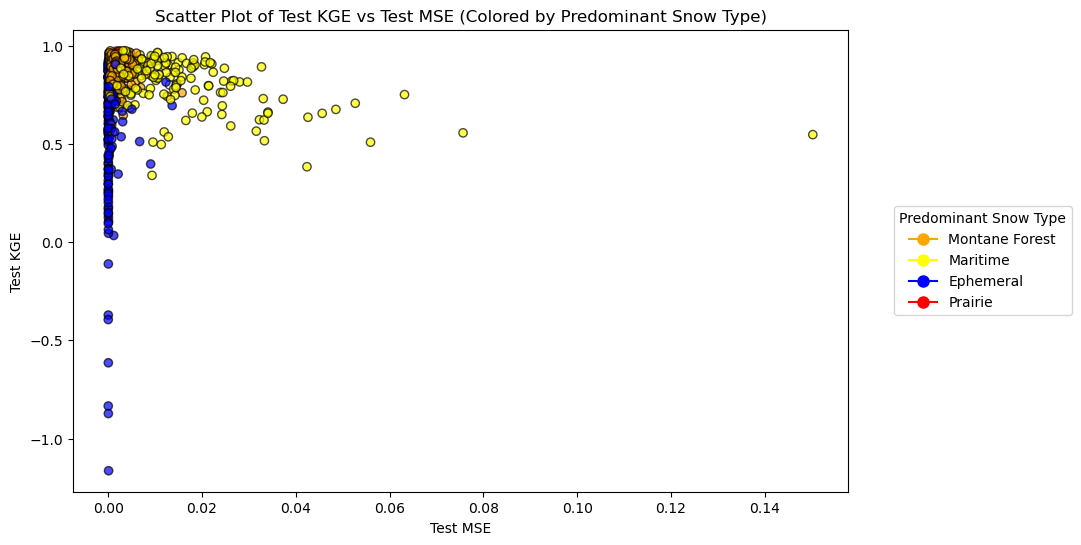

In [9]:
# All results 
plot_scatter(df_metrics, color_map)

In [10]:
# Results with Ephemeral Removed 
df_noE = df_metrics[df_metrics["Predominant_Snow"] != "Ephemeral"]
print(df_noE.shape)

(354, 13)


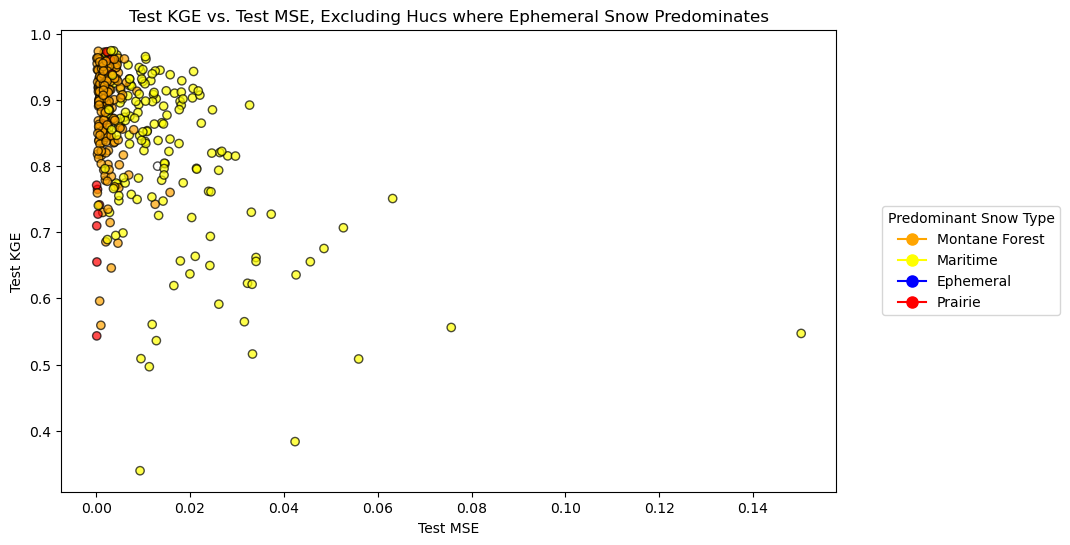

In [11]:
ttl = "Test KGE vs. Test MSE, Excluding Hucs where Ephemeral Snow Predominates"
plot_scatter(df_noE, color_map, title = ttl)

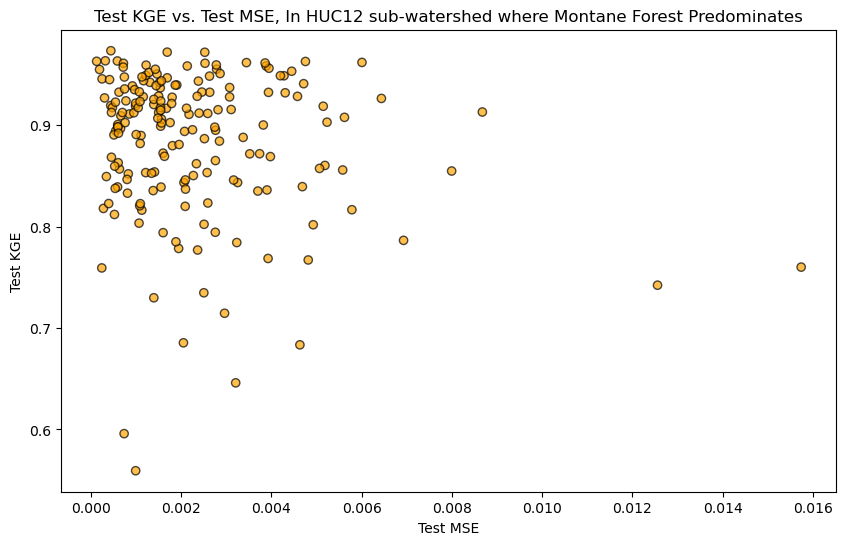

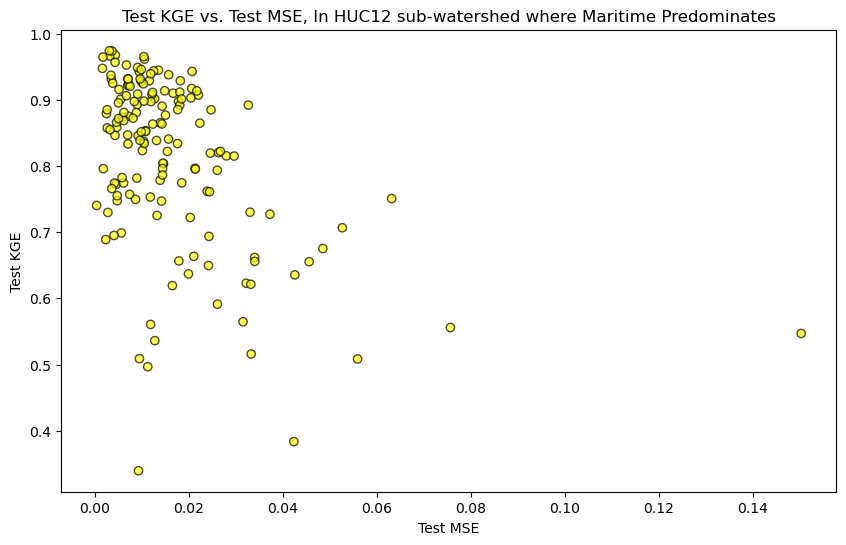

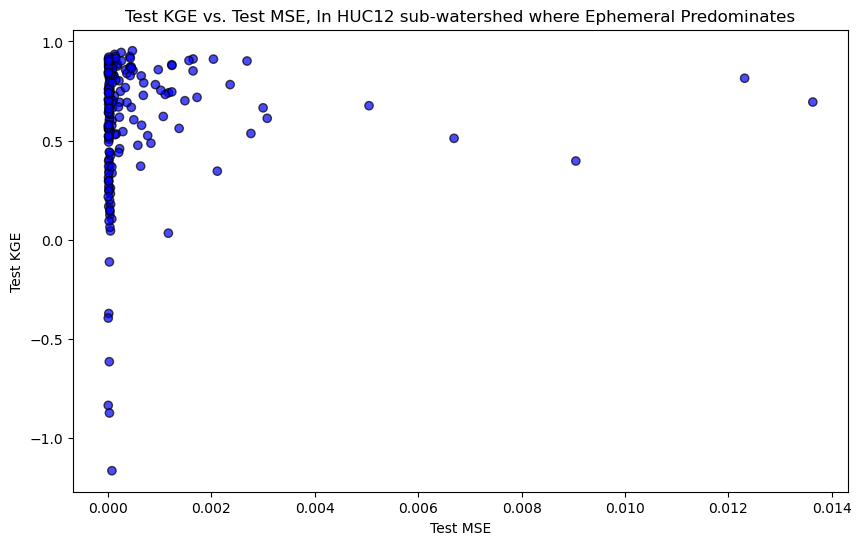

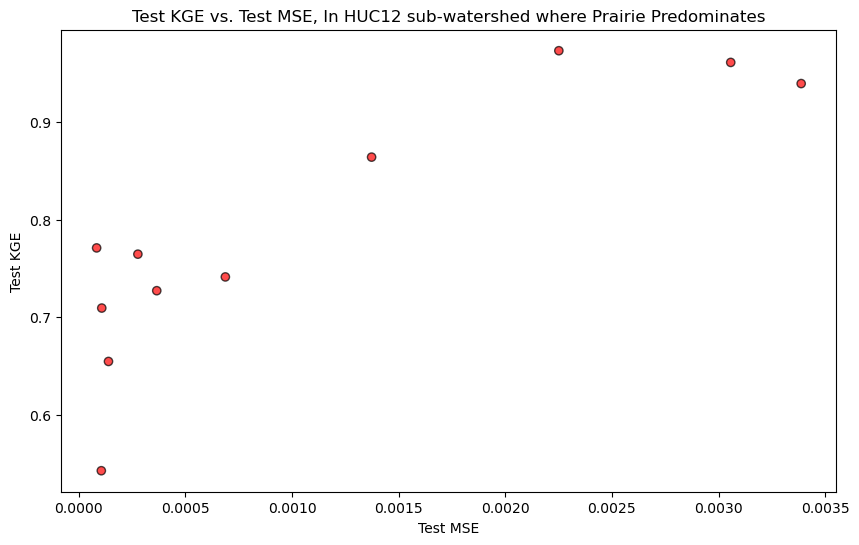

In [12]:
# Scatterlot by snowtype 

for snowtype in color_map.keys():
    df_st = df_metrics[df_metrics["Predominant_Snow"] == snowtype]
    #print(df_st.head(2))
    ttl = f"Test KGE vs. Test MSE, In HUC12 sub-watershed where {snowtype} Predominates"
    plot_scatter(df_st, color_map, title = ttl, show_legend = False)

# NOTE THAT EACH PLOT HAS A DIFFERENT SCALE IN ORDER TO VISUALIZE DIFFERENCES WITHIN SNOWCLASS 
# BUT CAREFUL RE COMPARING ACCROSS SNOWTYPES USING THE BELOW
    

In [13]:
# Step 4 - Investigate Individual Hucs w/ KGE and MSE Mismatch

In [14]:
kge_low_thresh = .7
kge_high_thresh = .9
mse_low_thresh = .001
mse_high_thresh = .02

In [15]:
def select_sample(df, kge_low_thresh=np.inf, kge_high_thresh=-np.inf, mse_low_thresh=np.inf, mse_high_thresh=-np.inf):
    """
    Selects Huc_Id values that meet the specified threshold conditions.

    Parameters:
    df (pd.DataFrame): The input dataframe with columns "Test MSE", "Test KGE", and "Huc_Id".
    kge_low_thresh (float, optional): Upper bound for "Test KGE" (default: infinity).
    kge_high_thresh (float, optional): Lower bound for "Test KGE" (default: negative infinity).
    mse_low_thresh (float, optional): Upper bound for "Test MSE" (default: infinity).
    mse_high_thresh (float, optional): Lower bound for "Test MSE" (default: negative infinity).

    Returns:
    pd.Series: A Series containing Huc_Id values that meet the conditions.
    """
    filtered_df = df[
        (df["Test MSE"] > mse_high_thresh) & 
        (df["Test MSE"] < mse_low_thresh) & 
        (df["Test KGE"] > kge_high_thresh) & 
        (df["Test KGE"] < kge_low_thresh)
    ]
    
    return filtered_df



# Step 5 - Create box and whisker plot 

In [16]:
low_low = select_sample(df_noE, kge_low_thresh = kge_low_thresh, mse_low_thresh = mse_low_thresh)
print(low_low.shape)
low_low.head()
# Use 170602071105

(4, 13)


,HUC_ID,Name,Test MSE,Test KGE,Predominant_Snow,mean_elevation,Huc_08,Huc_08_nm,geometry,Snow_Type_Color,Test KGE Class,Test KGE color,Elevation Category
104,170200100304,Cobaley Canyon,0.000139,0.654953,Prairie,868.775391,17020010,Upper Columbia-Entiat,POLYGON ((-120.08949879410966 47.7278635578490...,red,Marginal,darkgray,lower mid
111,170200100311,Beaver Creek,0.000105,0.543307,Prairie,948.342773,17020010,Upper Columbia-Entiat,POLYGON ((-120.11048028866757 47.4062487769740...,red,Marginal,darkgray,lower mid
374,170602071105,Bear Creek-Salmon River,0.000989,0.559327,Montane Forest,1363.657104,17060207,Middle Salmon-Chamberlain,POLYGON ((-115.81069435102609 45.4680499224330...,orange,Marginal,darkgray,mid
376,170602071107,Carey Creek-Salmon River,0.000733,0.595868,Montane Forest,1537.429932,17060207,Middle Salmon-Chamberlain,POLYGON ((-115.94211095861817 45.4550281970231...,orange,Marginal,darkgray,upper mid


In [17]:
high_low = select_sample(df_noE, kge_high_thresh = kge_high_thresh, mse_low_thresh = mse_low_thresh)
print(high_low.shape)
high_low.head()
# Use 170200090304

(28, 13)


,HUC_ID,Name,Test MSE,Test KGE,Predominant_Snow,mean_elevation,Huc_08,Huc_08_nm,geometry,Snow_Type_Color,Test KGE Class,Test KGE color,Elevation Category
5,170103020301,Twomile Creek-South Fork Coeur d'Alene River,0.000849,0.910887,Montane Forest,1126.706055,17010302,South Fork Coeur d'Alene,POLYGON ((-115.93841588362378 47.5194054160430...,orange,Excellent,green,mid
7,170103020303,Bear Creek-South Fork Coeur d'Alene River,0.000591,0.900435,Montane Forest,1012.606689,17010302,South Fork Coeur d'Alene,POLYGON ((-116.13540999444459 47.6034987992638...,orange,Excellent,green,mid
23,170103040308,Siwash Creek-St Joe River,0.000739,0.947341,Montane Forest,1256.440796,17010304,St. Joe,POLYGON ((-115.64229800319683 47.2936115134265...,orange,Excellent,green,mid
45,170103040803,Carpenter Creek,0.000986,0.918758,Montane Forest,1067.016235,17010304,St. Joe,POLYGON ((-116.37277239472816 47.0975335239173...,orange,Excellent,green,mid
87,170200090304,First Creek-Lake Chelan,0.000437,0.919176,Montane Forest,937.027222,17020009,Lake Chelan,POLYGON ((-120.15743752366797 47.8916434241358...,orange,Excellent,green,lower mid


In [18]:
# Exclude Prarie and Boreal sub, hucs.  Optionally exclude Ephemeral 
snow_types_to_include = ["Montane Forest", "Ephemeral", "Maritime"]
filtered_df = df_metrics[df_metrics["Predominant_Snow"].isin(snow_types_to_include)]

snow_types_to_include = ["Montane Forest", "Maritime"]
filtered_df_MandM = df_metrics[df_metrics["Predominant_Snow"].isin(snow_types_to_include)]



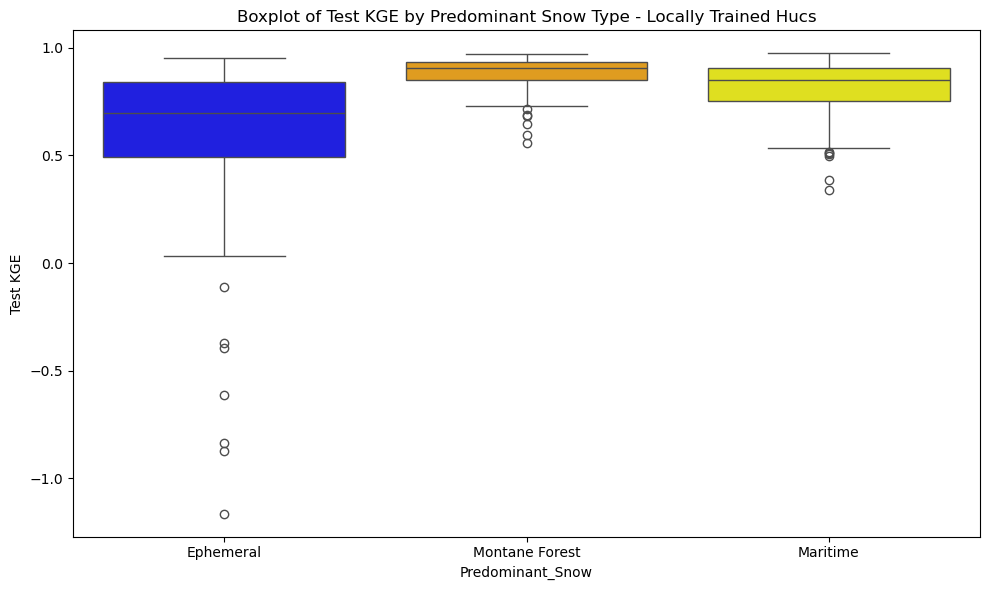

In [33]:
parameter = "Test KGE"
color_map = {"Ephemeral": "blue", "Montane Forest": "orange", "Maritime": "yellow"}
ttl = f"Boxplot of {parameter} by Predominant Snow Type - Locally Trained Hucs"
group_by = "Predominant_Snow"
plot_boxplot_by_group(filtered_df, parameter, title= ttl, groupby_column = group_by, color_map = color_map)


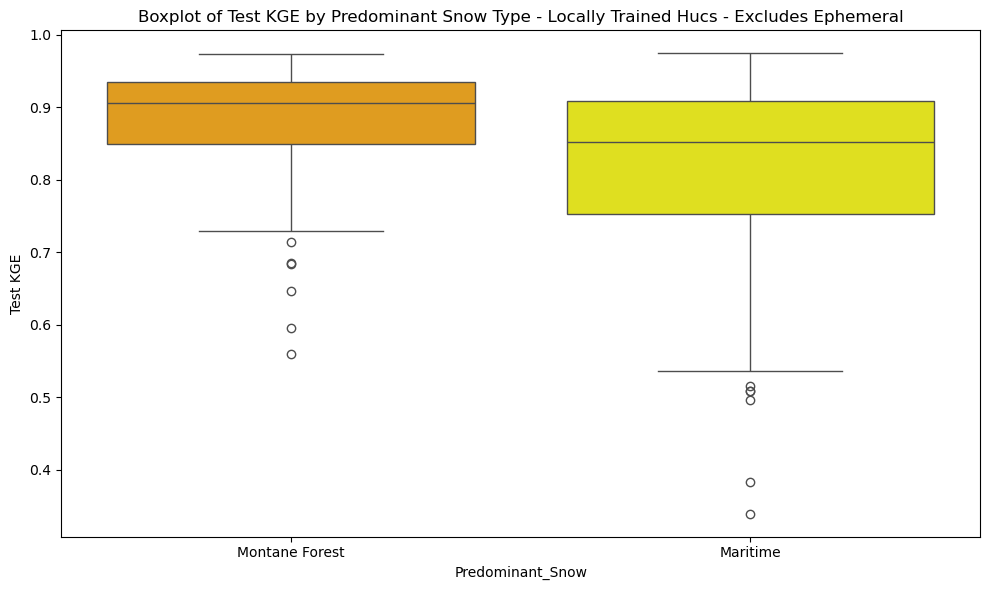

In [34]:
parameter = "Test KGE"
color_map = {"Montane Forest": "orange", "Maritime": "yellow"}
ttl = f"Boxplot of {parameter} by Predominant Snow Type - Locally Trained Hucs - Excludes Ephemeral"
group_by = "Predominant_Snow"
plot_boxplot_by_group(filtered_df, parameter, title= ttl, groupby_column = group_by, color_map = color_map)

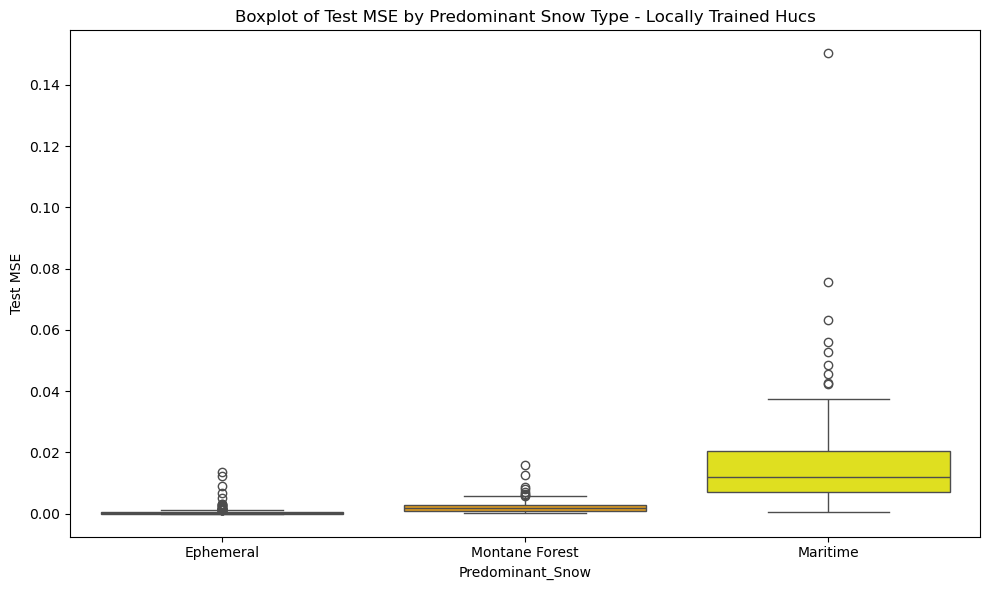

In [35]:
parameter = "Test MSE"
color_map = {"Ephemeral": "blue", "Montane Forest": "orange", "Maritime": "yellow"}
ttl = f"Boxplot of {parameter} by Predominant Snow Type - Locally Trained Hucs"
group_by = "Predominant_Snow"
plot_boxplot_by_group(filtered_df, parameter, title= ttl, groupby_column = group_by, color_map = color_map)

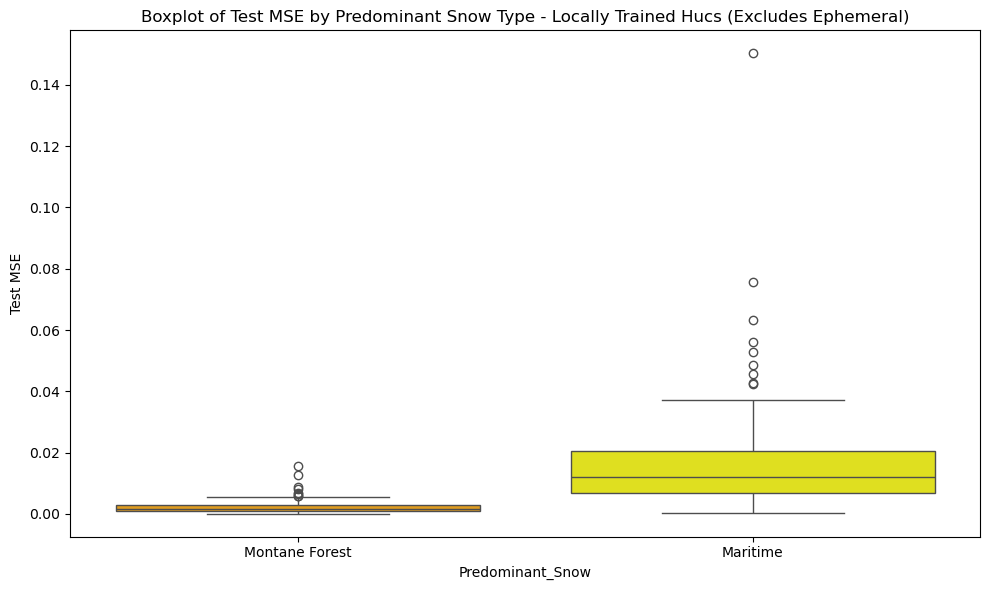

In [36]:

parameter = "Test MSE"
ttl = f"Boxplot of {parameter} by Predominant Snow Type - Locally Trained Hucs (Excludes Ephemeral)"
color_map = {"Montane Forest": "orange", "Maritime": "yellow"}
group_by = "Predominant_Snow"
plot_boxplot_by_group(filtered_df, parameter, title= ttl, groupby_column = group_by, color_map = color_map)

# Step 6 Examine by Basin

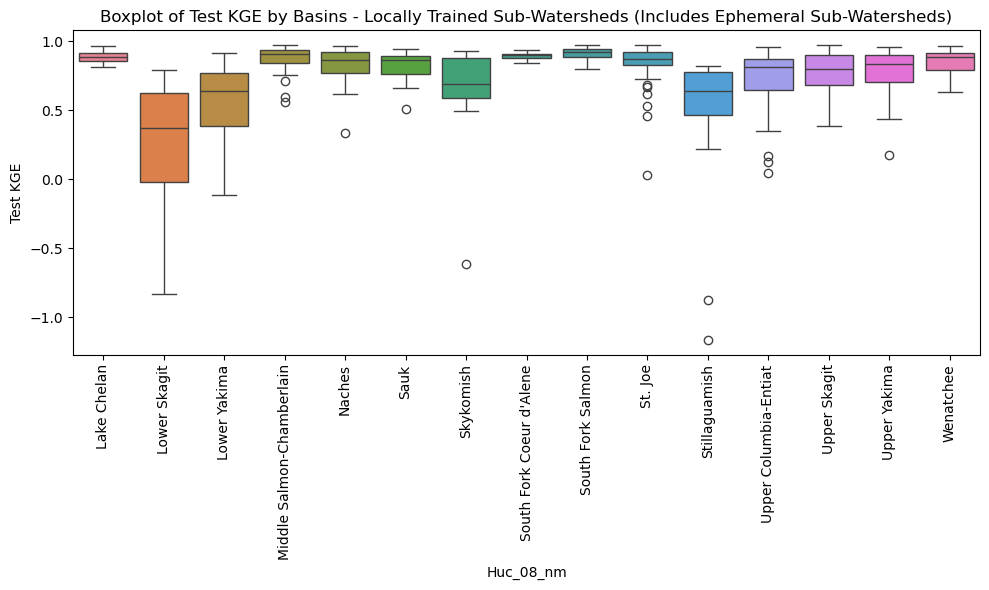

In [47]:
parameter = "Test KGE"
groupby ="Huc_08_nm"
ttl = f"Boxplot of {parameter} by Basins - Locally Trained Sub-Watersheds (Includes Ephemeral Sub-Watersheds)"
plot_boxplot_by_group(filtered_df, parameter, title= ttl, groupby_column = groupby, trunc = True)

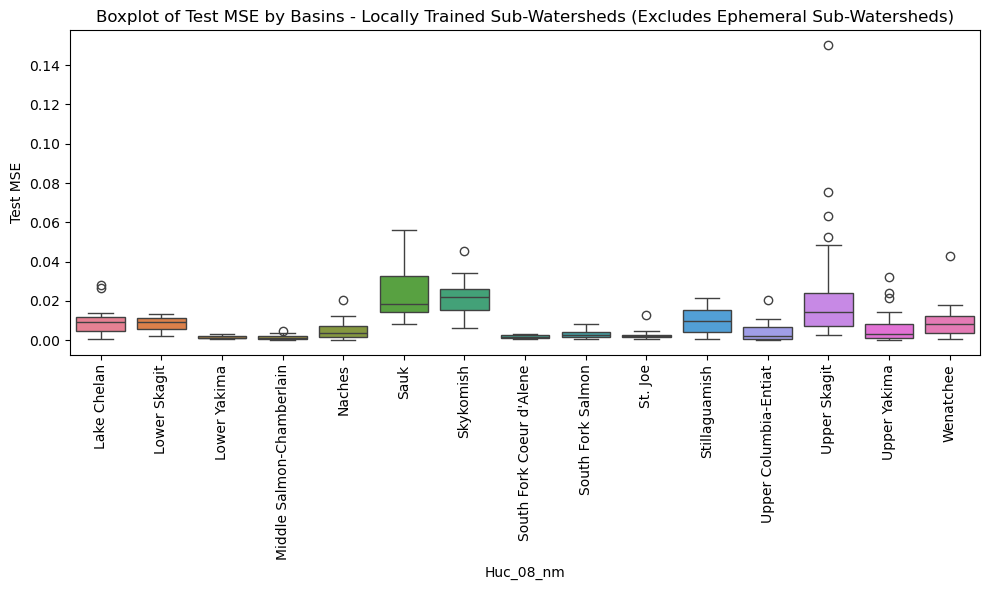

In [48]:
parameter = "Test MSE"
groupby ="Huc_08_nm"
ttl = f"Boxplot of {parameter} by Basins - Locally Trained Sub-Watersheds (Excludes Ephemeral Sub-Watersheds)"
plot_boxplot_by_group(filtered_df_MandM, parameter, title= ttl, groupby_column = groupby, trunc = True)

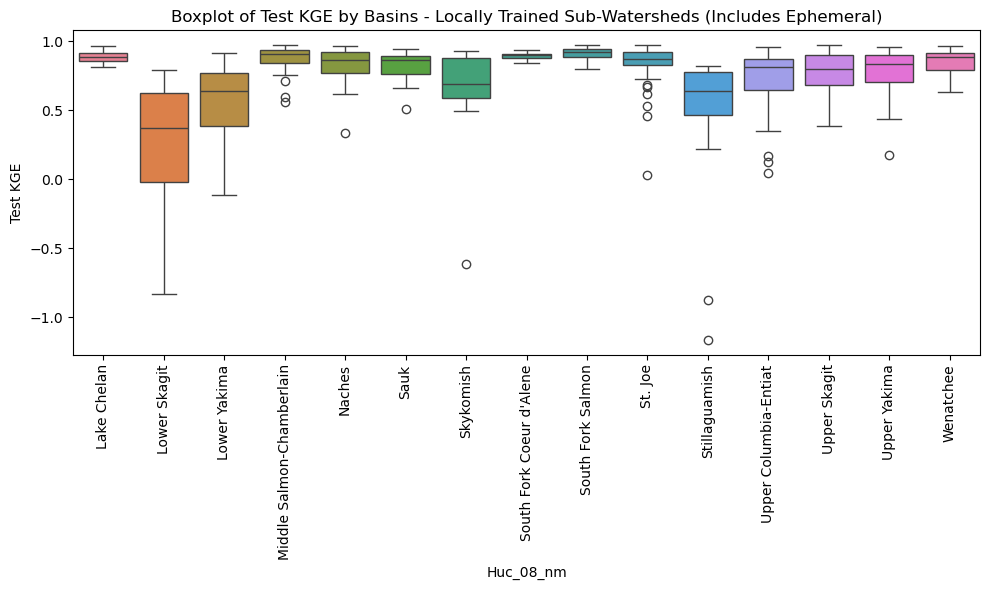

In [49]:
parameter = "Test KGE"
groupby ="Huc_08_nm"
ttl = f"Boxplot of {parameter} by Basins - Locally Trained Sub-Watersheds (Includes Ephemeral)"
plot_boxplot_by_group(filtered_df, parameter, title= ttl, groupby_column = groupby, trunc = True)

# Step 7 Examine by Elevation 

In [50]:
filtered_df.head(2)

,HUC_ID,Name,Test MSE,Test KGE,Predominant_Snow,mean_elevation,Huc_08,Huc_08_nm,geometry,Snow_Type_Color,Test KGE Class,Test KGE color,Elevation Category
0,170103020101,Little North Fork South Fork Coeur d'Alene Riv...,0.002073,0.893745,Montane Forest,1430.934082,17010302,South Fork Coeur d'Alene,"POLYGON ((-115.629450541972 47.47961590993951,...",orange,Good,lightgreen,mid
1,170103020102,Canyon Creek-Upper South Fork Coeur d'Alene River,0.001535,0.936654,Montane Forest,1445.485107,17010302,South Fork Coeur d'Alene,POLYGON ((-115.75460827799712 47.5523761135482...,orange,Excellent,green,mid


In [51]:
# Count occurrences of each elevation category
elevation_counts = filtered_df['Elevation Category'].value_counts()

# Print the counts
print(elevation_counts)
print(np.sum(elevation_counts))

Elevation Category
mid          176
lower mid    137
upper mid    104
low           64
high          41
Name: count, dtype: int64
522


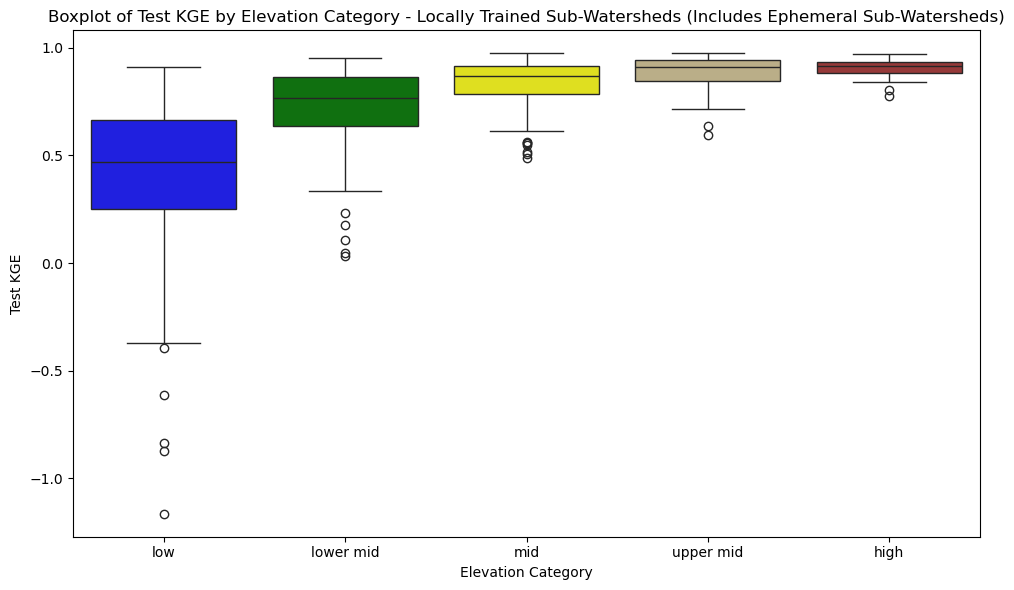

In [53]:
parameter = "Test KGE"
groupby ="Elevation Category"
ttl = f"Boxplot of {parameter} by {groupby} - Locally Trained Sub-Watersheds (Includes Ephemeral Sub-Watersheds)"
color_map = {"low": "blue", "lower mid": "green", "mid": "yellow", "upper mid": "#C2B280", "high": "#A52A2A"}
plot_boxplot_by_group(filtered_df, parameter, title= ttl, groupby_column = groupby, color_map = color_map)

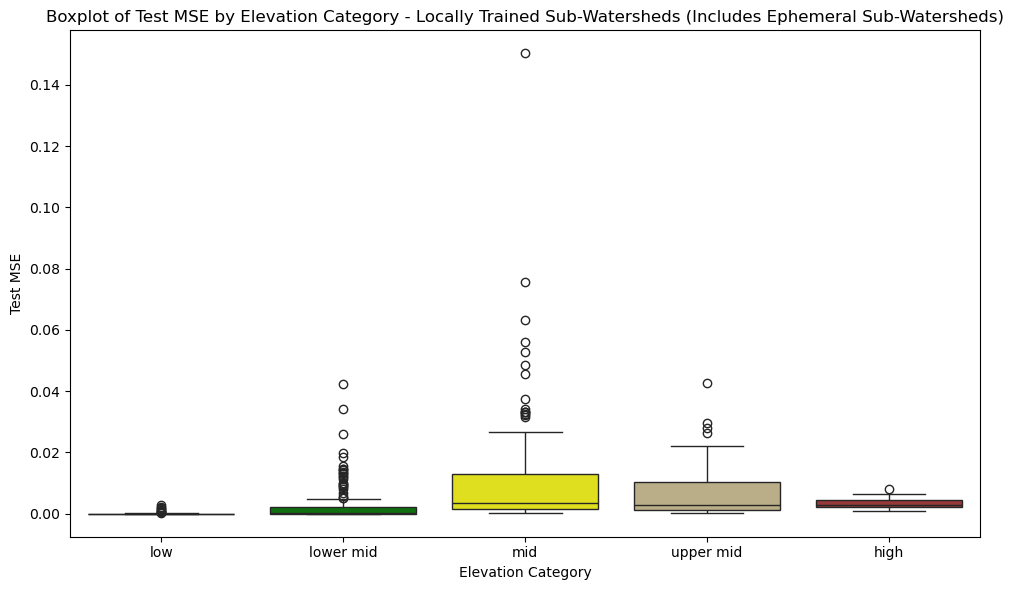

In [55]:
parameter = "Test MSE"
groupby ="Elevation Category"
ttl = f"Boxplot of {parameter} by {groupby} - Locally Trained Sub-Watersheds (Includes Ephemeral Sub-Watersheds)"
color_map = {"low": "blue", "lower mid": "green", "mid": "yellow", "upper mid": "#C2B280", "high": "#A52A2A"}
plot_boxplot_by_group(filtered_df, parameter, title= ttl, groupby_column = groupby, color_map = color_map)

# By Elevation and Predom Snow Types 

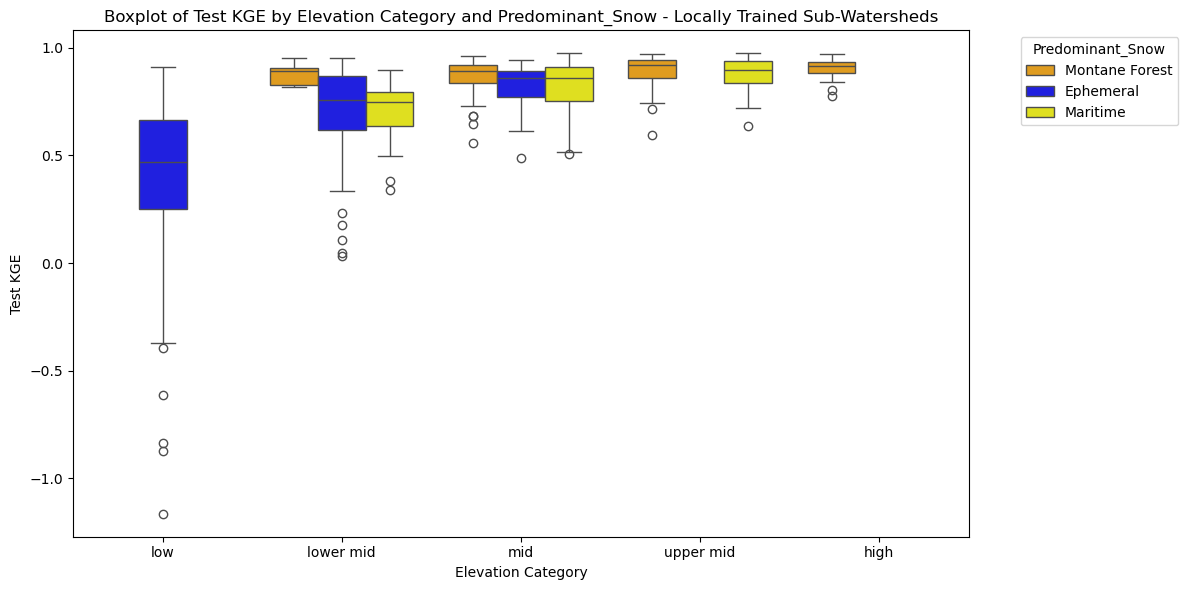

In [69]:
parameter = "Test KGE"
group_by1 =  "Elevation Category"
group_by2 =  "Predominant_Snow"
color_map = {"Ephemeral": "blue", "Montane Forest": "orange", "Maritime": "yellow"}
cat_order = ["low", "lower mid", "mid", "upper mid", "high"]
ttl = f"Boxplot of {parameter} by {group_by1} and {group_by2} - Locally Trained Sub-Watersheds"
plot_boxplot_by_2group(filtered_df, parameter, ttl, group_by1, group_by2,  
                           color_map=color_map, category_order=cat_order)


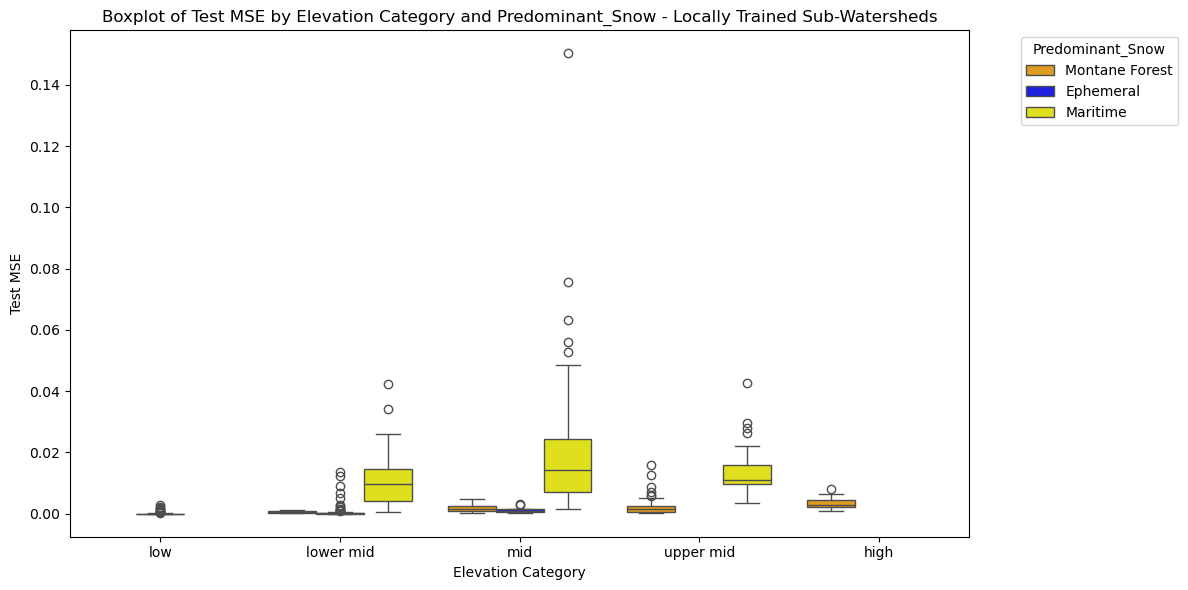

In [70]:

parameter = "Test MSE"
group_by1 =  "Elevation Category"
group_by2 =  "Predominant_Snow"
color_map = {"Ephemeral": "blue", "Montane Forest": "orange", "Maritime": "yellow"}
cat_order = ["low", "lower mid", "mid", "upper mid", "high"]
ttl = f"Boxplot of {parameter} by {group_by1} and {group_by2} - Locally Trained Sub-Watersheds"
plot_boxplot_by_2group(filtered_df, parameter, ttl, group_by1, group_by2,  
                           color_map=color_map, category_order=cat_order)


In [ ]:
parameter = "Test MSE"
group_by1 = "Predominant_Snow"
group_by2 ="Elevation Category"
ttl = f"Boxplot of {parameter} by {group_by1} and {group_by2} - Locally Trained Sub-Watersheds"
plot_boxplot_by_two_groups(metrics_w_elev_MandM, parameter, group_by1=group_by1, group_by2=group_by2, title=ttl)

# Step Last Examine Outliers

In [ ]:
# extract the five rows with highest MSE - what do they have in common? 
largest_mse = (df_metrics.nlargest(5, "Test MSE"))
print(largest_mse)

In [ ]:
for huc_id in largest_mse["HUC_ID"]:
    geos = gg.get_geos_with_name(huc_id, '12')
    #print(geos)
    largest_mse.loc[largest_mse["HUC_ID"] == huc_id, "Name"] = geos.iloc[0]["name"]
    largest_mse.loc[largest_mse["HUC_ID"] == huc_id, "geometry"] = geos.iloc[0]["geometry"]
largest_mse_gdf = gpd.GeoDataFrame(largest_mse, geometry="geometry")
largest_mse_gdf.set_crs("EPSG:4326", inplace=True) 

largest_mse_gdf

In [ ]:
largest_mse_gdf.explore()